In [ ]:
!pip install -U bentoml

## Imports

In [3]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-alpha0


## Loading the Fashion MNIST dataset

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocessing the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

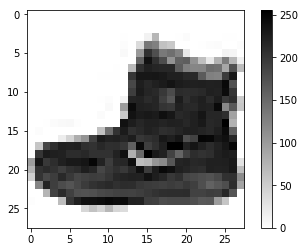

In [7]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We should scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [8]:
train_images = train_images / 255.0

test_images = test_images / 255.0

## Displaying 25 images from the training and testing sets

In [9]:
def show_25(images, labels):
    
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

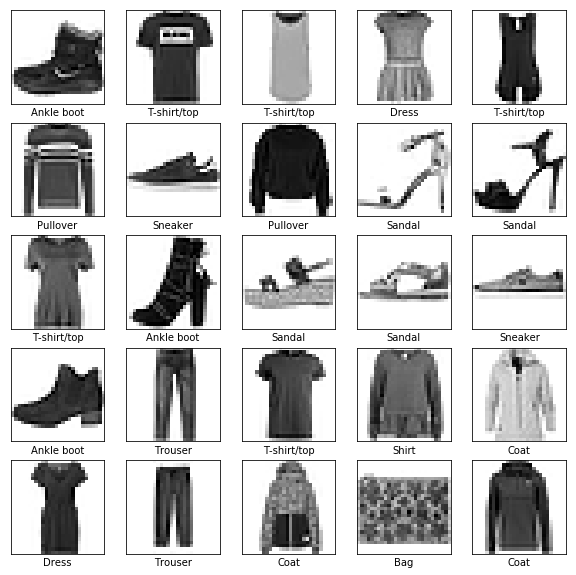

In [10]:
show_25(train_images, train_labels)

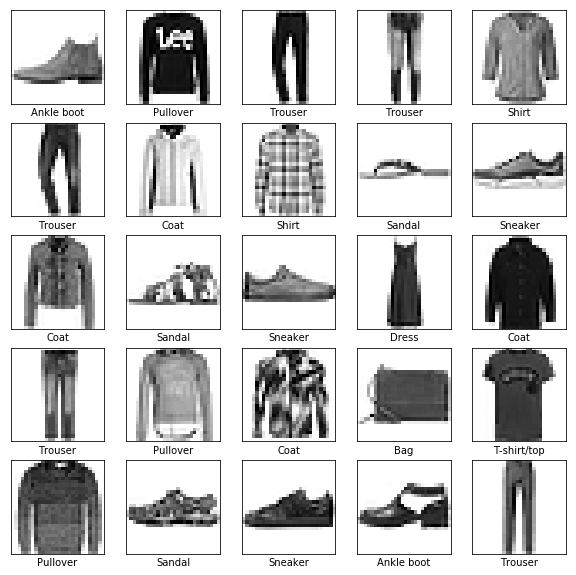

In [11]:
show_25(test_images, test_labels)

## Building a simple ConvNet

In [12]:
# Reshaping the images so that our model can accept it
train_images  = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [13]:
# Define the Convolutional Neural Network

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu')
])

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

## Compiling the model

In [14]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training the model

In [15]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 32s 527us/sample - loss: 0.5063 - accuracy: 0.8142
Epoch 2/5
60000/60000 [==============================] - 30s 500us/sample - loss: 0.3203 - accuracy: 0.8834
Epoch 3/5
60000/60000 [==============================] - 30s 502us/sample - loss: 0.2747 - accuracy: 0.8989
Epoch 4/5
60000/60000 [==============================] - 34s 563us/sample - loss: 0.2447 - accuracy: 0.9094
Epoch 5/5
60000/60000 [==============================] - 33s 551us/sample - loss: 0.2209 - accuracy: 0.9186


## Evaluation on the test set

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 2s 169us/sample - loss: 0.2744 - accuracy: 0.9014
Test accuracy: 0.9014


## Making prediction on a single image

Let's first see the test image and and its label:

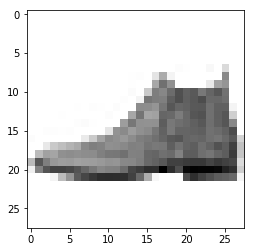


Class 9


In [23]:
plt.imshow(test_images[0].squeeze(-1), cmap=plt.cm.binary)
plt.show()
print('\nClass', test_labels[0])

In [20]:
import numpy as np

model.predict_classes(np.expand_dims(test_images[0], 0))

array([9])

So model made the correct prediction on the first image. You can go on and try a few but I will leave it here. 

## Incorporate `bentoml` to serve the model

### Exporting the model

In [30]:
%%writefile tf_keras_fashion_mnist.py

import bentoml
from bentoml import api, artifacts, env, BentoService
from bentoml.artifact import TfKerasModelArtifact
from bentoml.handlers import TensorflowTensorHandler
from io import BytesIO
from scipy.misc import imresize, imread

@bentoml.env(conda_dependencies=['tensorflow', 'numpy'])
@bentoml.artifacts([TfKerasModelArtifact('classifier')])
class TfKerasFashionMnistModel(bentoml.BentoService):
    
    @bentoml.api(TensorflowTensorHandler)
    def predict(self, request):
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        
        input_file = request.files.get('file')
        if not input_file:
            return BadRequest("File is not present in the request")
        if input_file.filename == '':
            return BadRequest("Filename is not present in the request")
        if not input_file.filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            return BadRequest("Invalid file type")

        input_buffer = BytesIO()
        input_file.save(input_buffer)
        image_array = imread(input_buffer, mode='L')
        
        image_array_re = imresize(image_array, (28, 28))
        image_array_re = image_array_re.reshape(1, 28, 28, 1)
        preds = model.predict(image_array_re)
        category_int = np.argmax(preds, axis=1)
        return class_names[int(category_int)]

Overwriting tf_keras_fashion_mnist.py


### Saving the model

In [31]:
from tf_keras_fashion_mnist import TfKerasFashionMnistModel

bento_model = TfKerasFashionMnistModel.pack(classifier=model)
saved_path = bento_model.save('/tmp/bento')
print(saved_path)

/tmp/bento/TfKerasFashionMnistModel/2019_06_04_5f446211
